## Q3

In [745]:
import os
import pandas as pd
import numpy as np
from collections import Counter
from tabulate import tabulate
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [746]:
## import df
ROOT_DIR = os.path.realpath(os.getcwd())
df_train = pd.read_csv(os.path.join(ROOT_DIR, 'train.csv'))
df_test = pd.read_csv(os.path.join(ROOT_DIR, 'test.csv'))

In [747]:
print(df_train.shape)
df_train.head()

(500, 6)


,X1,X2,X3,X4,X5,Y
0,1,1,0,1,1,0
1,0,0,1,1,0,0
2,1,1,1,0,1,1
3,0,0,0,0,0,0
4,0,0,0,1,1,0


In [748]:
print(df_test.shape)
df_test.head()

(100, 6)


,X1,X2,X3,X4,X5,Y
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,1,0,0,1,1,1
3,0,0,0,1,0,0
4,0,0,0,0,0,0


In [749]:
df_train.head()

,X1,X2,X3,X4,X5,Y
0,1,1,0,1,1,0
1,0,0,1,1,0,0
2,1,1,1,0,1,1
3,0,0,0,0,0,0
4,0,0,0,1,1,0


In [750]:
train = df_train.values
test = df_test.values
X_train = train[:, :-1]
X_test = test[:, :-1]
y_train = train[:, -1]
y_test = test[:, -1]

## 5 X in total

### Q3a

In [752]:
class Variable_Importance:
    """
    Class with calculations of variable importance
    """
    
    def __init__(self):
        self.gini_pre = None
        
        self.reduction_lst = None
        self.similarity_lst = None
        self.best_impurity_reduction = float('-inf')
        self.best_reduction_index = None
        self.surrogate_similarity = float('-inf')
        self.surrogate_similarity_index = None
        self.surrogate_impurity_reduction = float('-inf')
        
        
    def _gini(self, y):
        """y array like"""
        p1 = np.sum(y == 1) / len(y)
        return 1 - p1**2 - (1-p1)**2
    
    def gini_post(self, x, y):
        """x array like
        calculate gini impurity after split"""
        mask_left = x <= 0.5
        mask_right = ~mask_left
        p1_left = np.sum(mask_left & (y == 1)) / np.sum(mask_left)
        p1_right = np.sum(mask_right & (y == 1)) / np.sum(mask_right)
        w_left = np.sum(mask_left) / len(x)
        w_right = 1 - w_left
        gini_split = ((1 - p1_left**2 - (1-p1_left)**2) * w_left + 
                      (1 - p1_right**2 - (1-p1_right)**2) * w_right)
        return gini_split
    
    def get_impurity_reduction(self, x, x_s, y):
        """get impurity reduction after split"""
        if x_s is None:
            return self.gini_pre - self.gini_post(x, y)
        else:
            return (self.gini_pre - self.gini_post(x_s, y))
        
    def get_lambda(self, x, x_s, y):
        """predictive similarity measure for surrogate variable"""
        idx_left = np.where(x <= 0.5)
        idx_right = np.where(x > 0.5)
        idx_leftj = np.where(x_s <= 0.5)
        idx_rightj = np.where(x_s > 0.5)
        p1j = idx_left[0].shape[0] / len(x)
        p0j = 1 - p1j
        p1j_s = (np.intersect1d(idx_left, idx_leftj)).shape[0] / len(x)
        p0j_s = (np.intersect1d(idx_right, idx_rightj)).shape[0] / len(x)
        return (min(p1j, p0j) - (1-p1j_s-p0j_s)) / min(p1j, p0j)
    
    
    
    
    def best_split_(self):
        X = self.X
        y = self.y
        """"Find the column in X that gives the maximum Gini reduction."""
        gini_reduct_lst = []
        for i in range(X.shape[1]):
            x = X[:, i]
            gini_reduction = self.get_impurity_reduction(x, None, y)
            gini_reduct_lst.append(gini_reduction)
        self.reduction_lst = gini_reduct_lst
        self.best_impurity_reduction = max(gini_reduct_lst)
        self.best_reduction_index = gini_reduct_lst.index(self.best_impurity_reduction)
           
    def best_surrogate_split_(self):
        X = self.X
        y = self.y
        """Find the sorrogate column in X.
        To find sorrogate we have to use x, x_s, y"""
        if X.shape[1] == 1:
            self.similarity_lst = None
            self.surrogate_similarity = None
            self.surrogate_similarity_index = self.best_reduction_index
            self.surrogate_impurity_reduction = self.best_impurity_reduction
        else:
            similarity_lst = []
            x = X[:, self.best_reduction_index]
            for j in range(X.shape[1]):
                if j == self.best_reduction_index:
                    similarity_lst.append(np.nan)
                else:
                    x_s = X[:, j]
                    similarity = self.get_lambda(x, x_s, y)
                    similarity_lst.append(similarity)
            self.similarity_lst = similarity_lst
            self.surrogate_similarity = np.nanmax(similarity_lst)
            self.surrogate_similarity_index = similarity_lst.index(self.surrogate_similarity)
            self.surrogate_impurity_reduction = self.get_impurity_reduction(x, 
                                                        X[:, self.surrogate_similarity_index], y)
        
    def straified_avg_(self, indices, values, n, f_n):
        """Given feature indices chosen for each stump and corresponding impurity reduction value
        Find the average impurity reduction for each feature in a random forest;
        a list of avg, with len = 5
        """
        impurity_avg_lst = []
        for i in range(f_n):
            if i in indices:
                result = (sum(val for idx, val in zip(indices, values) if idx == i)) / indices.count(i)
                impurity_avg_lst.append(result)
            else:
                impurity_avg_lst.append(0)
        return impurity_avg_lst

  
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.gini_pre = self._gini(y)
    


In [753]:
## measure of variable importance
## max of impurity reduction
model = Variable_Importance()
model.fit(X_train, y_train)

In [754]:
model.best_split_()
model.best_surrogate_split_()

print(f'Best variable: X{model.best_reduction_index+1}\n'
      f'  Impurity reduction: {model.best_impurity_reduction}')
print(f'Best surrogate variable: X{model.surrogate_similarity_index+1}\n'
      f'  Predictive similarity: {model.surrogate_similarity}\n'
      f'  Impurity reduction of surrogate: {model.surrogate_impurity_reduction}')

Best variable: X1
  Impurity reduction: 0.27031854977502356
Best surrogate variable: X2
  Predictive similarity: 0.6008230452674896
  Impurity reduction of surrogate: 0.10556222981883367


In [755]:
print('The best split of decision stump is X1, the best surrogate split is X2. Since they are all binary, '
      'we consider the cutoff as 0.5 for both off them, with left split as X1 <= 0.5 and right as X1 > 0.5. '
      'X2 is the same. The variable importance measurements for the best split and the best surrogate split is '
      f'{round(model.best_impurity_reduction, 4)} and {round(model.surrogate_impurity_reduction, 4)} respectively. '
      'This suggested that X2 is more important than others.')


The best split of decision stump is X1, the best surrogate split is X2. Since they are all binary, we consider the cutoff as 0.5 for both off them, with left split as X1 <= 0.5 and right as X1 > 0.5. X2 is the same. The variable importance measurements for the best split and the best surrogate split is 0.2703 and 0.1056 respectively. This suggested that X2 is more important than others.


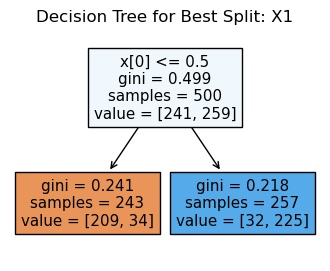

In [756]:
## apply sklearn decision tree
best_df = (df_train.iloc[:, [0, 5]]).values
best_tst_df = (df_test.iloc[:, [0, 5]]).values

surrogate_df = (df_train.iloc[:, [1, 5]]).values
surrogate_tst_df = (df_test.iloc[:, [1, 5]]).values

## X, y, split for best and surrogate
Xj_train, yj_train = best_df[:, 0].reshape(-1, 1), best_df[:, 1]
Xj_tst, yj_tst = best_tst_df[:, 0].reshape(-1, 1), best_tst_df[:, 1]

X_js_train, y_js_train = surrogate_df[:, 0].reshape(-1, 1), surrogate_df[:, 1]
X_js_tst, y_js_tst = surrogate_tst_df[:, 0].reshape(-1, 1), surrogate_tst_df[:, 1]


## classifier fit, plt_tree, predict
### best split (X1) tree
model = DecisionTreeClassifier(random_state=42)
clf1 = model.fit(Xj_train, yj_train)

plt.figure(figsize=(4, 3))
plot_tree(clf1, filled=True)
plt.title('Decision Tree for Best Split: X1')
plt.show()


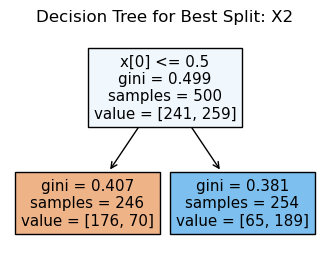

In [757]:
### surrogate split (X2) tree
clf2 = model.fit(X_js_train, y_js_train)
plt.figure(figsize=(4, 3))
plot_tree(clf2, filled=True)
plt.title('Decision Tree for Best Split: X2')
plt.show()


In [758]:
## misclssification error for two splits
y_pred_j = clf.predict(Xj_tst)
error_j = 1 - accuracy_score(yj_tst, y_pred_j)
y_pred_js = clf2.predict(X_js_tst)
error_js = 1 - accuracy_score(y_js_tst, y_pred_js)

## mean misclassification error of best split and surrogate split
print(f'Best split misclassification error: {round(error_j, 4)}')
print(f'Surrogate split misclassification error: {round(error_js, 4)}')

Best split misclassification error: 0.1
Surrogate split misclassification error: 0.27


### Q3b

In [759]:
# RandomForestClassifier
## bootstrap = True
## max_samples = 0.8 *n
## n_estimators = 1000
## max_features = 1,2,3,4,5
## max_depth = 1

#      Root (split on some feature)
#     /    \
# Leaf (-2)  Leaf (-2)

In [760]:
class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, data_left=None, data_right=None, imp_reduct=None, value=None):
        self.feature = feature
        self.data_left = data_left
        self.data_right = data_right
        self.imp_reduct = imp_reduct
        self.value = value

In [761]:
class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    
    def __init__(self, max_depth = 1):
        """
        max_depth   : tree depth
        """
        self.max_depth = max_depth
        self.root = None
        
    def _gini(self, y):
        """
        Function to calculate gini before split.
        
        :param y: np.array, target
        :return float (gini impurity before split)
        """
        p1 = np.sum(y == 1) / len(y)
        return 1 - p1**2 - (1-p1)**2
    
    def _gini_post(self, x, y):
        """
        Function used for calcualting gini impurity after split.
        
        :param x: np.array, a single feature
        :param y: np.array, target
        :return float (gini impurity after split)
        """
        mask_left = x <= 0.5
        mask_right = ~mask_left
        p1_left = np.sum(mask_left & (y == 1)) / np.sum(mask_left)
        p1_right = np.sum(mask_right & (y == 1)) / np.sum(mask_right)
        w_left = np.sum(mask_left) / len(x)
        w_right = 1 - w_left
        gini_split = ((1 - p1_left**2 - (1-p1_left)**2) * w_left + 
                      (1 - p1_right**2 - (1-p1_right)**2) * w_right)
        return gini_split
    
    def _gini_reduction(self, x, y):
        """
        Helper function used for calcualting gini reduction.
        
        :param x: np.array, a single feature
        :param y: np.array, target
        :return float (gini reduction)
        """
        return self._gini(y) - self._gini_post(x, y)
        
    def _best_split(self, X, y):
        """
        Helper function to find best split based on gini reduction.
        
        :param X: np.array, features
        :param y: np.array, target
        :return dict (best_split: feature_index, left_leaf, right_leaf, impurity_reduction)
        """
        gini_reduct_lst = []
        for i in range(X.shape[1]):
            x = X[:, i]
            gini_reduction = self._gini_reduction(x, y)
            gini_reduct_lst.append(gini_reduction)
        ## get best impurity reduction and corresponding feature index
        imp_reduct = max(gini_reduct_lst)
        f_idx = gini_reduct_lst.index(imp_reduct)
        ## split to left and right leaf
        arr = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        mask = arr[:, f_idx] <= 0.5
        left = arr[mask]
        right = arr[~mask]
        ## save as dictionary
        best_split = {
            'feature_index': f_idx,
            'data_left': left,
            'data_right': right,
            'impurity_reduction': imp_reduct
        }
        return best_split
        
        
    def _build(self, X, y):
        '''
        Helper function, used to build a decision tree from the input data.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: Node
        '''
        ## get best feature ot split on
        best = self._best_split(X, y)
        ## majority vote to get left and right value
        left_value = Counter(best['data_left'][:, -1]).most_common(1)[0][0]
        right_value = Counter(best['data_right'][:, -1]).most_common(1)[0][0]
        ## build left and right leaf
        left = Node(value=left_value)
        right = Node(value=right_value)
        ## construct node and relate the two leaves
        return Node(
            feature=best['feature_index'], 
            data_left=left, 
            data_right=right, 
            imp_reduct=best['impurity_reduction']
        )
        
        
    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self._build(X, y)
        
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).
        
        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        # Go to the left
        if feature_value <= 0.5:
            return self._predict(x=x, tree=tree.data_left)
        # Go to the right
        if feature_value > 0.5:
            return self._predict(x=x, tree=tree.data_right)
        
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        
        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return np.array([self._predict(x, self.root) for x in X])
    


In [762]:
class RandomForest:
    
    def __init__(self, n_estimators = 1000, max_features = 5, max_samples = 100, max_depth = 1, random_state = 42):
        """
        n_estimators: number of trees in forest
        max_features: feature subset size for fitting a tree
        max_samples : bootstrap sample size
        max_depth   : tree depth
        
        decision_trees    : store individual trained decision trees
        best_feature_idxs : store best splitting feature index
        surro_feature_idxs: store surrogate split feature index
        """
        ## hyperparameters
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.random_state = random_state
        ## save produced variable importance metrics
        self.best_feature_idxs = None
        self.surro_feature_idxs = None
        self.best_reduction_lst = None
        self.surro_reduction_lst = None
        self.oob_err_lst = None
        self.impurity_avg_lst = None
        self.oob_err_avg_lst = None
        ## save decision trees
        self.trees = []
        ## save pred_matrix
        self.pred_mat = []
        ## set seed
        np.random.seed(self.random_state)
        
    def _bootstrap(self, X, y):
        """
        Helper function used for boostrap sampling.
        
        :param X: np.array, features
        :param y: np.array, target
        :return tuple (sample of features, sample of target / in pandas form)
        """
        data = pd.DataFrame(X)
        target = pd.DataFrame(y)
        bootstrap_indices = np.random.choice(len(X), self.max_samples, replace=True)
        oob_indices = list(set(range(X.shape[0])) - set(bootstrap_indices))
        return (data.iloc[bootstrap_indices, :], target.iloc[bootstrap_indices,:], 
                data.iloc[oob_indices, :], target.iloc[oob_indices,:])
    
    def _sample_feature(self, X):
        """
        Helper function used for feature subset sampling.
        
        :param X: pd.DataFrame, features
        :return array (sampled subset of features)
        """
        feature_indices = np.random.choice(X.shape[1], self.max_features, replace=False)
        return X.iloc[:, feature_indices]

    def _build_trees(self, X, y):
        """
        Build decision trees for forest.
        
        :param X: np.array, features
        :param y: np.array, target
        :return None
        """
        # Build each tree of the forest
        num_built = 0
        while num_built < self.n_estimators:
            ## import decision tree
            model = DecisionTree(max_depth = self.max_depth)
            ## select bootstrap and feature subset
            X_bootstrap, y_bootstrap, X_oob, y_oob = self._bootstrap(X, y)
            _X_df, _y_df = self._sample_feature(X_bootstrap), y_bootstrap
            _X, _y = _X_df.values, np.array(_y_df).flatten()
            ## train decision tree
            model.fit(_X, _y)
            ## save decision tree
            tree_dict = {
                        'clf': model, 
                        'feature_idxs': np.array(_X_df.columns),
                        'bootstrap_idxs': np.array(_X_df.index), 
                        'oob_idxs': np.array(y_oob.index)
                        }
            self.trees.append(tree_dict)
            num_built += 1
            
    def variable_importance_(self, X, y):
        """
        Output function for calculating variable importance.
        
        :param X: np.array, features
        :param y: np.array, target
        :return None
        """
        ## Initialization
        self.best_feature_idxs = []  ## len = 1000
        self.best_reduction_lst = [] ## len = 1000
        self.surro_feature_idxs = [] ## len = 1000
        self.surro_reduction_lst = []## len = 1000
        self.oob_err_lst = []        ## len = 1000
        self.impurity_avg_lst = []   ## len = 5
        self.oob_err_avg_lst = []    ## len = 5
        
        for tree_dict in self.trees:
            ## get the df used for training
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)
            clf = tree_dict['clf']
            feature_idxs = tree_dict['feature_idxs']
            bootstrap_idxs = tree_dict['bootstrap_idxs']
            oob_idxs = tree_dict['oob_idxs']
            _X_df, _y_df = X.iloc[bootstrap_idxs, feature_idxs], y.iloc[bootstrap_idxs, ]
            _X, _y = _X_df.values, np.array(_y_df).flatten()
            ## fit for variable importance
            calculator = Variable_Importance()
            calculator.fit(_X, _y)
            
            ## best split
            calculator.best_split_()
            best_feature_idx = _X_df.columns[calculator.best_reduction_index]
            self.best_feature_idxs.append(best_feature_idx)
            self.best_reduction_lst.append(calculator.best_impurity_reduction)
            ## surrogate split
            calculator.best_surrogate_split_()
            self.surro_feature_idxs.append(_X_df.columns[calculator.surrogate_similarity_index])
            self.surro_reduction_lst.append(calculator.surrogate_impurity_reduction)
            ## calculate permuted “out-of-bag” error (Step 1)
            _X_oob, _y_oob = (X.iloc[oob_idxs, feature_idxs]).values, np.array(y.iloc[oob_idxs, ]).flatten()
              ## predict before permutation
            y_pred_oob = clf.predict(_X_oob)## note: the #columns of X_test input should match x_train
            _X_oob_permute = _X_oob.copy()
            np.random.shuffle(_X_oob_permute)
              ## predict after permutation
            y_pred_oob_permute = clf.predict(_X_oob_permute)
            
            
              ## calcualte error
            oob_err = self.squares_error(_y_oob, y_pred_oob_permute) - self.squares_error(_y_oob, y_pred_oob)
            self.oob_err_lst.append(oob_err)
            
        ## calculate RF based avg impurity
        self.impurity_avg_lst = calculator.straified_avg_(self.best_feature_idxs, self.best_reduction_lst, 
                                                          self.n_estimators, X.shape[1])
        ## alculate permuted “out-of-bag” error (Step 2)
        self.oob_err_avg_lst = calculator.straified_avg_(self.best_feature_idxs, self.oob_err_lst, 
                                                         self.n_estimators, X.shape[1])
            

            
    def squares_error(self, y_true, y_pred):
        """
        Helper function for calculating least squares error.
        
        :params y_true: np.array, true values of y
        :params y_pred: np.array, predicted values of y
        """
        return np.sum((y_true - y_pred)**2) / len(y_true)

    
    def fit(self, X, y):
        """
        Trains a Random Forest classifier.
        
        :param X: np.array, features
        :param y: np.array, target
        """
        ## Build each tree of the forest
        self._build_trees(X, y)
        ## store variable importance data
        self.variable_importance_(X, y)

        
    def predict(self, X):
        '''
        Predicts class labels for new data instances.
        
        :param X: np.array, new instances to predict
        :return: 
        '''
        y_pred = []
        for tree_dict in self.trees:
            clf = tree_dict['clf']
            feature_idxs = tree_dict['feature_idxs']
            y_pred.append(clf.predict(X[:, feature_idxs]))
        y_pred = np.swapaxes(a=y_pred, axis1=0, axis2=1)
        self.pred_mat = y_pred
        
        # Use majority voting for the final prediction
        predictions = []
        for preds in y_pred:
            counter = Counter(preds)
            predictions.append(counter.most_common(1)[0][0])
        return predictions
        
        

In [765]:
## times of each variable used for the best split

train = df_train.values
test = df_test.values
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = test[:, :-1]
y_test = test[:, -1]

for i in range(5):
    model = RandomForest(n_estimators=1000, 
                         max_features=i+1,
                         max_samples = int(0.8*train.shape[0]),
                         max_depth=1,
                         random_state = 42
                        )
    model.fit(X_train, y_train)
    ## count feature best split frequency
    counter_f_idxs1 = []
    for f_idx in range(5):
        if f_idx in model.best_feature_idxs:
            counter_f_idxs1.append((model.best_feature_idxs).count(f_idx))
        else:
            counter_f_idxs1.append(0)
    ## count feature surrogate split frequency
    counter_f_idxs2 = []
    for f_idx in range(5):
        if f_idx in model.surro_feature_idxs:
            counter_f_idxs2.append((model.surro_feature_idxs).count(f_idx))
        else:
            counter_f_idxs2.append(0)
    ## get variable importance calculated by (5) and (6)
    gini_avg_lst = model.impurity_avg_lst
    err_avg_lst = model.oob_err_avg_lst

    ## organize results
    print(f'K = {i+1}')
    df = pd.DataFrame({
        'Best Split Count': counter_f_idxs1,
        'Surr Split Count': counter_f_idxs2,
        'Gini Reduction Avg': gini_avg_lst,
        'OOB Error Avg': err_avg_lst
    }, index=['X1', 'X2', 'X3', 'X4', 'X5'])
    
    display(df)

    ## predict and compare two losses
    y_pred = model.predict(X_test)
    loss1 = 1-accuracy_score(y_test, y_pred)
    print(f'Majority Vote Prediction Loss: {loss1}')
    tree_accuracys = []
    pred_matrix = model.pred_mat
    pred_matrix = np.swapaxes(a=pred_matrix, axis1=0, axis2=1)
    for pred in pred_matrix:
        tree_accuracys.append(1-accuracy_score(y_test, pred))
    loss2 = np.mean(tree_accuracys)
    print(f'Tree Average Prediction Loss: {loss2}')
    print('-------------------------------------')


K = 1


,Best Split Count,Surr Split Count,Gini Reduction Avg,OOB Error Avg
X1,187,187,0.270867,0.363445
X2,210,210,0.104580,0.234096
X3,192,192,0.001793,-0.002913
X4,195,195,0.001613,-0.005350
X5,216,216,0.001416,-0.008772


Majority Vote Prediction Loss: 0.14
Tree Average Prediction Loss: 0.3798500000000001
-------------------------------------
K = 2


,Best Split Count,Surr Split Count,Gini Reduction Avg,OOB Error Avg
X1,415,0,0.269131,0.364173
X2,298,111,0.106398,0.233303
X3,107,289,0.003104,-0.003810
X4,96,284,0.002864,-0.006142
X5,84,316,0.002610,-0.015652


Majority Vote Prediction Loss: 0.10999999999999999
Tree Average Prediction Loss: 0.26473
-------------------------------------
K = 3


,Best Split Count,Surr Split Count,Gini Reduction Avg,OOB Error Avg
X1,616,0,0.268744,0.366886
X2,303,307,0.106026,0.232122
X3,31,237,0.003255,-0.007540
X4,28,167,0.003123,-0.008367
X5,22,289,0.002586,-0.014487


Majority Vote Prediction Loss: 0.09999999999999998
Tree Average Prediction Loss: 0.18336000000000002
-------------------------------------
K = 4


,Best Split Count,Surr Split Count,Gini Reduction Avg,OOB Error Avg
X1,815,0,0.269149,0.367348
X2,185,609,0.106628,0.228608
X3,0,133,0.000000,0.000000
X4,0,56,0.000000,0.000000
X5,0,202,0.000000,0.000000


Majority Vote Prediction Loss: 0.09999999999999998
Tree Average Prediction Loss: 0.13145000000000004
-------------------------------------
K = 5


,Best Split Count,Surr Split Count,Gini Reduction Avg,OOB Error Avg
X1,1000,0,0.269141,0.366815
X2,0,1000,0.000000,0.000000
X3,0,0,0.000000,0.000000
X4,0,0,0.000000,0.000000
X5,0,0,0.000000,0.000000


Majority Vote Prediction Loss: 0.09999999999999998
Tree Average Prediction Loss: 0.1
-------------------------------------


#### For the above table, the first column is the count of features as best split in forest, the second one is the count of features as surrogate split, the third is variable importance calculated by equation (5). The fourth is the variable importance calculated by equation (6).

#### At every last after the table we have the mean misclassification error on test set calculated in 2 ways. The first line is calculated using the majority vote of the stumps as the prediction and compute the loss, the second line is calculated by finding the predictions of each stump, compute the loss on each, and average the results. 

#### The numeric results are all listed in the output of the chunk above. 

#### The number of times for each variable selected as best split and surrogate split for each K is listed above. For the best split, X1 is the most important variable in the random forest fitting, since X1 is about 100%, 80%, 60% and 40% treated as best split when K=5, 4, 3, 2 respectively, where X1 is the most common among all others. X2 is about 100%, 60%, 30% chance treated as surrogate split when K=5, 4, 3 respectively. In addition, X2 is the second variable that is most likely be selectd as best split (when X1 is excluded), which can be proved in the table when K=4, 3.

#### According to the variable importance calculated by (5) and (6), X1 and X2 are more important than the others. More specifically, the {Gini Reduction Avg} calculated by (5) for X1 and X2 are way more higher than the other variables, with X2 lower than X1. The {OOB Error Avg} calculated by (6) has the value for X1 and X2 as positive numbers, and X3, X4, X5 as negative values. This means that after shuffling / disrupting the relation between X1 / X2 and y, the error would increases and affect the prediction. For X3, X4, X5, we have negative variable importance values, which is also close to 0, which means that shuffling of these variables may not affect the prediction.

#### If we are only focusing on the largest variable importance values, then surely X2 is still suffering from masking and masking hide the importance of X2 as much as it does with decision stumps, since for two variable importance, X1 has the largest values for both of them. If we are considering on comparing the variable importance across all the variables, then we will still be able to see that X2 is very important.

#### As for the mean misclassification error calculation, we should use the first method (use the majority vote of the stumps as the prediction and compute the loss). The main reason is that we are calculating the error of the random forest, which can be also considered as the comparison between y_true and y_pred. But for the second method, it does not gave an output of y_pred. The main thing is that random forest is for prediction, not just for calculating the error. Then we would rather give an difference between the predicted y from random forest and the true values of y.

### Q3c

In [779]:
## times of each variable used for the best split

train = df_train.values
test = df_test.values
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = test[:, :-1]
y_test = test[:, -1]

q_lst = [0.4, 0.5, 0.6, 0.7, 0.8]

for q in q_lst:
    model = RandomForest(n_estimators=1000, 
                         max_features=2,
                         max_samples = int(q*train.shape[0]),
                         max_depth=1,
                         random_state = 42
                        )
    model.fit(X_train, y_train)
    ## count feature best split frequency
    counter_f_idxs1 = []
    for f_idx in range(5):
        if f_idx in model.best_feature_idxs:
            counter_f_idxs1.append((model.best_feature_idxs).count(f_idx))
        else:
            counter_f_idxs1.append(0)
    ## count feature surrogate split frequency
    counter_f_idxs2 = []
    for f_idx in range(5):
        if f_idx in model.surro_feature_idxs:
            counter_f_idxs2.append((model.surro_feature_idxs).count(f_idx))
        else:
            counter_f_idxs2.append(0)
    ## get variable importance calculated by (5) and (6)
    gini_avg_lst = model.impurity_avg_lst
    err_avg_lst = model.oob_err_avg_lst

    ## organize results
    print(f'B = {int(q*train.shape[0])}, q = {q}')
    df = pd.DataFrame({
        'Best Split Freq': counter_f_idxs1,
        'Surr Split Freq': counter_f_idxs2,
        'Gini Reduction Avg': gini_avg_lst,
        'OOB Error Avg': err_avg_lst
    }, index=['X1', 'X2', 'X3', 'X4', 'X5'])
    
    display(df)



B = 200, q = 0.4


,Best Split Freq,Surr Split Freq,Gini Reduction Avg,OOB Error Avg
X1,377,0,0.266725,0.367668
X2,314,86,0.105371,0.228321
X3,103,297,0.005039,-0.004547
X4,110,318,0.004611,-0.005150
X5,96,299,0.004365,-0.008369


B = 250, q = 0.5


,Best Split Freq,Surr Split Freq,Gini Reduction Avg,OOB Error Avg
X1,377,0,0.267092,0.367149
X2,307,100,0.106677,0.231908
X3,113,297,0.004308,-0.003365
X4,99,294,0.005170,-0.006291
X5,104,309,0.003313,-0.008121


B = 300, q = 0.6


,Best Split Freq,Surr Split Freq,Gini Reduction Avg,OOB Error Avg
X1,399,0,0.267595,0.365611
X2,287,99,0.104205,0.232760
X3,108,319,0.003879,-0.004530
X4,105,299,0.004092,-0.002724
X5,101,283,0.003002,-0.015781


B = 350, q = 0.7


,Best Split Freq,Surr Split Freq,Gini Reduction Avg,OOB Error Avg
X1,387,0,0.268011,0.369771
X2,297,85,0.107972,0.229741
X3,105,302,0.003336,-0.007663
X4,101,303,0.003276,-0.011238
X5,110,310,0.002247,-0.007914


B = 400, q = 0.8


,Best Split Freq,Surr Split Freq,Gini Reduction Avg,OOB Error Avg
X1,415,0,0.269131,0.364173
X2,298,111,0.106398,0.233303
X3,107,289,0.003104,-0.003810
X4,96,284,0.002864,-0.006142
X5,84,316,0.002610,-0.015652


#### According to (5) and (6) calculation, X1 and X2 are more important than the others. More specifically, the {Gini Reduction Avg} calculated by (5) for X1 and X2 are way more higher than the other variables, with X2 lower than X1. The {OOB Error Avg} calculated by (6) has the value for X1 and X2 as positive numbers, and X3, X4, X5 as negative values. The conclusion is similar to the last question.